# Semantic Drift Analysis and Pivotal Paper Identification

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from pymilvus import connections, Collection
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

load_dotenv()
MILVUS_HOST = os.environ["MILVUS_HOST"]
MILVUS_PORT = os.environ["MILVUS_PORT"]
COLLECTION_NAME = os.environ["MILVUS_COLLECTION_NAME"]
EMBEDDING_MODEL = os.environ["EMBEDDING_MODEL"]
DB_USER = os.environ["POSTGRES_USER"]
DB_PASSWORD = os.environ["POSTGRES_PASSWORD"]
DB_HOST = os.environ["POSTGRES_HOST"]
DB_PORT = os.environ["POSTGRES_PORT"]
DB_NAME = os.environ["POSTGRES_DB"]
DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

connections.connect("default", host=MILVUS_HOST, port=MILVUS_PORT)
print(f"Milvus connected at {MILVUS_HOST}:{MILVUS_PORT}")
collection = Collection(COLLECTION_NAME)
collection.load()
print(f"Collection '{COLLECTION_NAME}' loaded with {collection.num_entities} entities.")

engine = create_engine(DATABASE_URL)
print("Postgres connected")

model = SentenceTransformer(EMBEDDING_MODEL)
print(f"Model '{EMBEDDING_MODEL}' loaded")

Milvus connected at webbc.duckdns.org:19530
Collection 'scientific_concepts' loaded with 1733417 entities.
Postgres connected
Model 'sentence-transformers/allenai-specter' loaded
Model 'sentence-transformers/allenai-specter' loaded


## Query

We will query for "Neural Networks" - this will allow us to sanity check since we should definitely see [Attention Is All You Need](https://arxiv.org/abs/1706.03762).

In [2]:
# Define the concept to track
QUERY_CONCEPT = "Neural Networks"
START_YEAR = 2015
END_YEAR = 2020

# Generate embedding for the query
query_embedding = model.encode([QUERY_CONCEPT], normalize_embeddings=True)[0]
print(f"Generated embedding for '{QUERY_CONCEPT}'")

Generated embedding for 'Neural Networks'


## Computing Yearly Centroids
To track how the concept moves through semantic space, we calculate a centroid for each year.

For every year in our range:
1.  We search Milvus for the top $K$ papers closest to our query vector.
2.  We take the average (mean) of these $K$ vectors to form the concept's centroid for that year.

In [3]:
def get_centroid_for_year(year: int, query_vec, k: int = 100):
    """
    Calculates the centroid of the top-k papers for the given query/year
    """
    results = collection.search(
        data = [query_vec], 
        anns_field = "embedding", 
        limit = k, 
        expr = f"year == {year}", # filter by year
        output_fields = ["embedding", "arxiv_id"],
        param = {
            "metric_type": "IP", 
            "params": {"nprobe": 10}
        }
    )
    
    if not results or len(results[0]) == 0:
        return None, []
    
    hits = results[0]
    vectors = np.array([hit.entity.get("embedding") for hit in hits])
    ids = [hit.entity.get("arxiv_id") for hit in hits]
    
    centroid = np.mean(vectors, axis=0)
    centroid_normalized = centroid / np.linalg.norm(centroid)
    
    return centroid_normalized, ids

centroids = {}
paper_ids_per_year = {}

print(f"Tracking concept '{QUERY_CONCEPT}' from {START_YEAR} to {END_YEAR}...")

empty_years = []
for year in tqdm(range(START_YEAR, END_YEAR + 1)):
    centroid, ids = get_centroid_for_year(year, query_embedding)
    if centroid is not None:
        centroids[year] = centroid
        paper_ids_per_year[year] = ids
    else:
        empty_years.append(year)

print(f"No data for years {empty_years}")
print(f"Computed centroids for {len(centroids)} years")

Tracking concept 'Neural Networks' from 2015 to 2020...


100%|██████████| 6/6 [00:00<00:00, 11.40it/s]

No data for years []
Computed centroids for 6 years


## Calculating Semantic Drift

To quantify the change we calculate the **Semantic Drift**, which is the cosine distance between the centroids of years $t-1$, $t$

$$
\text{Drift}_t = 1 - \text{CosineSimilarity}(C_{t-1}, C_t)
$$

A high $\text{Drift}_t$ indicates a significant shift in the underlying meaning or context of the papers discussing the concept.

In [4]:
from scipy.spatial.distance import cosine as cosine_distance

drift_metrics = []
years = sorted(centroids.keys())

for i in range(1, len(years)):
    prev_year, curr_year = years[i-1], years[i]
    c_prev, c_curr = centroids[prev_year], centroids[curr_year]
    
    # Cosine distance = 1 - cosine_similarity
    # scipy.spatial.distance.cosine returns the distance directly
    dist = cosine_distance(c_prev, c_curr)
    
    drift_metrics.append({
        "year": curr_year,
        "drift": dist,
        "prev_year": prev_year
    })

drift_df = pd.DataFrame(drift_metrics)
print(drift_df)

   year     drift  prev_year
0  2016  0.001701       2015
1  2017  0.002309       2016
2  2018  0.002773       2017
3  2019  0.002563       2018
4  2020  0.001615       2019


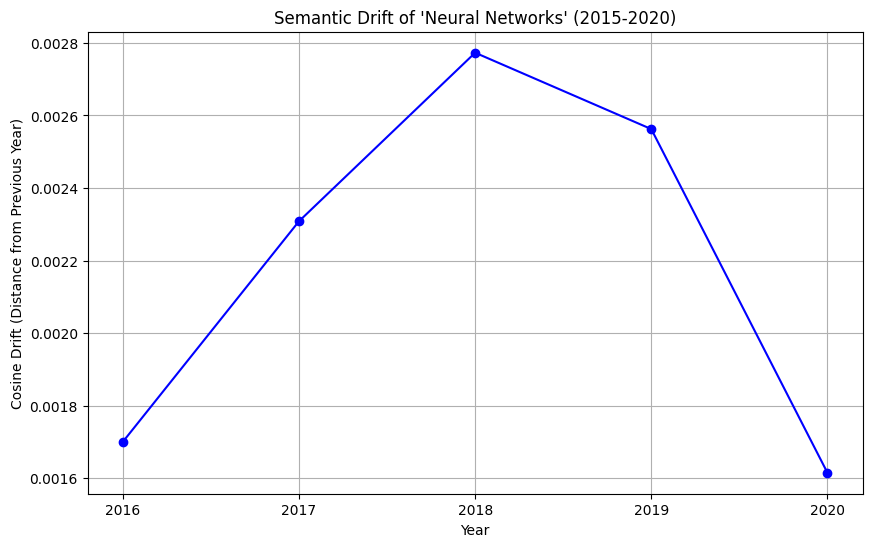

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(drift_df['year'], drift_df['drift'], marker='o', linestyle='-', color='b')
plt.title(f"Semantic Drift of '{QUERY_CONCEPT}' ({START_YEAR}-{END_YEAR})")
plt.xlabel("Year")
plt.ylabel("Cosine Drift (Distance from Previous Year)")
plt.grid(True)
plt.xticks(drift_df['year'])
plt.show()

## Identifying Pivotal Papers
Finally, we identify the specific year where the semantic drift was maximal. We then retrieve the titles and abstracts of the top papers from that year. These papers are likely the "pivotal" publications that drove the shift in meaning.

In [6]:
# get year with maximum drift
if not drift_df.empty:
    max_drift_row = drift_df.loc[drift_df['drift'].idxmax()]
    max_drift_year = int(max_drift_row['year'])
    max_drift_val = max_drift_row['drift']
    pivotal_ids = paper_ids_per_year[max_drift_year]
    
    # get title/abstracts from DB
    if pivotal_ids:
        formatted_ids = "', '".join(pivotal_ids[:5]) # Get top 5
        query = text(f"SELECT arxiv_id, title, published_date FROM papers WHERE arxiv_id IN ('{formatted_ids}')")
        
        with engine.connect() as conn:
            result = conn.execute(query)
            papers = result.fetchall()
            
        print(f"--- Top Pivotal Papers in {max_drift_year} (Drift: {max_drift_val:.4f}) ---")
        for p in papers:
            print(f"[{p.published_date}][{p.arxiv_id}] {p.title}")
else:
    print("Not enough data to calculate drift.")

--- Top Pivotal Papers in 2018 (Drift: 0.0028) ---
[2018-01-14][1801.04540] Fix your classifier: the marginal value of training the last weight
  layer
[2018-01-17][1801.05894] Deep Learning: An Introduction for Applied Mathematicians
[2018-05-19][1805.07531] Neural networks with dynamical coefficients and adjustable connections
  on the basis of integrated backpropagation
[2018-06-01][1806.00179] The Nonlinearity Coefficient - Predicting Generalization in Deep Neural
  Networks
[2018-08-10][1808.04433] Out of the Black Box: Properties of deep neural networks and their
  applications


## Diagnosis

We should have seen [Attention Is All You Need](https://arxiv.org/abs/1706.03762) to appear as pivotal for "Neural Networks".

Let's see where it ranks for just 2017...

In [7]:
TARGET_ARXIV_ID = '1706.03762'
TARGET_YEAR = 2017

with engine.connect() as conn:
    query_paper = text(f"SELECT arxiv_id, title FROM papers WHERE arxiv_id = :arxiv_id")
    result = conn.execute(query_paper, {'arxiv_id': TARGET_ARXIV_ID}).fetchone()

if result:
    print(f"Found '{result.title}' ({TARGET_ARXIV_ID})")
    
    # get embedding from Milvus
    res = collection.query(
        expr=f"arxiv_id == '{TARGET_ARXIV_ID}'",
        output_fields=["embedding"]
    )
    
    if res:
        target_embedding = res[0]["embedding"]
        
        # Calculate Similarity to Query
        # cosine distance = 1 - similarity ==> we want similarity for ranking
        # But Milvus IP metric on normalized vectors = Cosine Similarity...
        # manually calculate dot product (since vectors are normalized)
        sim = np.dot(query_embedding, target_embedding)
        print(f"Similarity to '{QUERY_CONCEPT}': {sim:.4f}")
        
        # get papers from 2017 so we can rank
        search_res = collection.search(
            data=[query_embedding], 
            anns_field="embedding", 
            param={"metric_type": "IP", "params": {"nprobe": 10}}, 
            limit=500,
            expr=f"year == {TARGET_YEAR}",
            output_fields=["arxiv_id"]
        )
        
        hits = search_res[0]
        found_rank = None
        for i, hit in enumerate(hits):
            if hit.entity.get("arxiv_id") == TARGET_ARXIV_ID:
                found_rank = i + 1
                break
        
        if found_rank:
            print(f"Rank in {TARGET_YEAR} for '{QUERY_CONCEPT}': #{found_rank}")
        else:
            print(f"Not found in Top {len(hits)} for {TARGET_YEAR} (scores ranged between {hits[-1].score:.4f} and {hits[0].score:.4f})")
    else:
        print("Paper found in Postgres but not in Milvus?")
else:
    print(f"Paper with arxiv_id = '{TARGET_ARXIV_ID}' not found in Postgres.")

Found 'Attention Is All You Need' (1706.03762)
Similarity to 'Neural Networks': 0.7466
Not found in Top 500 for 2017 (scores ranged between 0.7752 and 0.8867)
